#Cheat sheet on kernel-based clustering

---
Clustering methods such as spectral clustering or weighted kernel k-means are popular algorithms for unsupervised learning. Since implementations are widely available they are easy to use and utilizing the kernel method makes them applicable to many problems, not only linear ones. However there are several variations and difficulties that sometimes require to take a second look at what is actually going on within the clustering algorithm. This notebook is intended as cheat sheet for quick reference. For detailed explanation the interested reader is refered to the list of literature referenced at [the end](#dhillon).

##Overview $\newcommand\v[1]{\boldsymbol{#1}} \newcommand\s[1]{\mathcal{#1}}$

---

The main advantage of kernel-based methods is that they allow us to design the problem directly in terms of data point similarities instead of transforming points to some abstract feature space. With respect to the clustering problem we can simply define a function that measures how equal a data pair is and use this information to decide on whether it belongs to the same cluster or not. Given a data set $\s V = \{\v x_i\}_i^n$ of $n$ data points, we construct a kernel $\v K \in \mathbb{R}^{n\times n}$ by using the kernel function $\v K_{ij} = \kappa(\v x_i,\v x_j)$. Some commonly used:

- **Polynomial:**
  > $\kappa(\v x_i,\v x_j) = (\v x_i^T \v x_j + c)^d$
  
- **Gaussian:**
  > $\kappa(\v x_i,\v x_j)=\exp(-\frac{1}{2\sigma^2}\|\v x_i-\v x_j\|^2)$

- **Sigmoid:**
  >$\kappa(\v x_i,\v x_j) = \tanh(c(\v x_i^T \v x_j) +\theta)$


Performing clustering on a kernel matrix $\v K$ can also be viewed from the graph partitioning perspective. Given graph $G = (\s V,\s E)$, each node in $\s V$ resembles one data point and a each edge in $\s E$ the similarity between two nodes defined by our kernel function $\kappa(\v x_i,\v x_j)$. Another noticable matrix when working with graphs is the diagonal degree matrix $\v D$ with entries $\v D_{ii} = \sum_{j=1}^n \kappa(\v x_i,\v x_j)$.
One can further define the similarity of two sets of nodes as 

$$ \delta(\s A,\s B) = \sum_{i \in \s A, j \in \s B} \kappa(\v x_i,\v x_j)$$

which is the sum of similarities that connects both sets. We can name
a few special cases:


- **Association:**
  > $\delta(\s V_c, \s V_c)$

- **Cut:**
  > $\delta(\s V_c, \s V\backslash \s V_c)$
 
- **Degree:**
  > $\delta(\s V_c, \s V)$

- **Association + Cut = Degree:**
  > $\delta(\s V_c, \s V_c) + \delta(\s V_c, \s V\backslash \s V_c) = \delta(\s V_c, \s V)$


The goal is to separate the nodes into $k$ clusters by finding a set 
of indicator vectors $\{\v y_c\}_1^k$ that determine whether a node belongs to the corresponding cluster ($\v y_c(i) = 1$).
The most common objectives are:

- **Average Association** which seeks to maximize the within-cluster similarity. Regular kernel $k$-means follows this objective.

  $$\max\left\{ 
  \sum_{c=1}^k \frac{\delta(\s V_c,\s V_c)}{|\s V_c|} 
  = \sum_{c=1}^k \frac{\v y_c^T \v K \v y_c}{\v y_c^T\v y_c}
  \right\}$$
  
  ---

- **Average Cut** which attempts to minimize the similarites between clusters. This is the objective used by spectral clustering with the graph laplacian $\v L=\v D-\v K$.

  $$\min\left\{
  \sum_{c=1}^k \frac{\delta(\s V_c,\s V\backslash\s V_c)}{|\s V_c|}
  = \sum_{c=1}^k \frac{\v y_c^T (\v D-\v K) \v y_c}{\v y_c^T\v y_c}
  \right\}$$
  
 ---
  
- **Normalized Cut** which places itself in between avg. cut and avg. association in order to achieve a trade-off of both objectives. Spectral clustering with $\v L = \v I -\v D^{-1/2}\v K\v D^{-1/2}$ and weighted kernel $k$-means use this.

  $$\min\left\{
  \sum_{c=1}^k \frac{\delta(\s V_c,\s V\backslash\s V_c)}{\delta(\s V_c,\s V)}
  = \sum_{c=1}^k \frac{\v y_c^T (\v D-\v K) \v y_c}{\v y_c^T \v D\v y_c}
  \right\}$$
  
  ---
  
- **Normalized Association** which is identical to normalized cuts but formulated as maximization:

  $$\max\left\{
  \sum_{c=1}^k \frac{\delta(\s V_c,\s V_c)}{\delta(\s V_c,\s V)}
  = \sum_{c=1}^k \frac{\v y_c^T \v K \v y_c}{\v y_c^T \v D\v y_c}
  \right\}$$
  
  ---
  
All objectives can also be written in trace maximization form and constraint that $\v Y^T\v Y = \v I_k$ is orthonormal:
$\newcommand\trace[1]{\mathrm{Tr}\left\{#1\right\}}$
- **AAssoc:**
  $$\max\; \trace{\v Y^T \v K \v Y}$$


- **ACut:**
  $$\max\; \trace{\v Y^T(\v I_n-(\v D-\v K))\v Y}$$


- **NCut/NAssoc:**
  $$\max\; \trace{\v Z^T \v D^{-1/2}\v K\v D^{-1/2}\v Z}$$
  
  with $\v Z = \v D^{1/2}\v Y$


##Experiments

___

Let us first load some libraries and set up a few settings:

In [48]:
%matplotlib inline
from pylab import *
from sklearn import datasets

kernel_plot_props = {
    "interpolation": 'none',
    #"norm": Normalize(vmin=0,vmax=1.),
    "cmap": get_cmap('RdBu')
}

Creating some toy dataset:

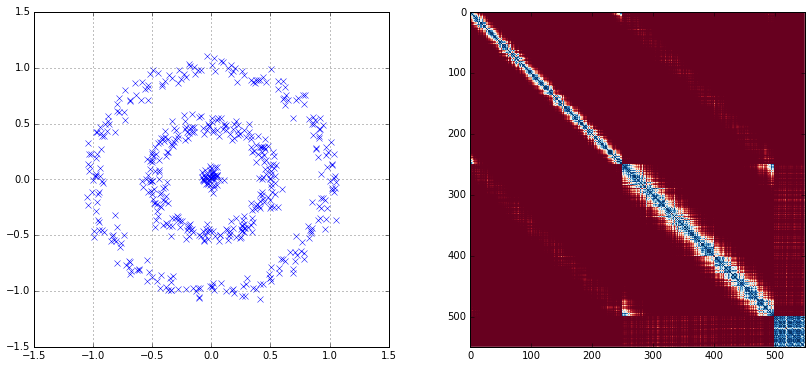

In [143]:
X,y = datasets.make_circles(n_samples=500,noise=0.05,factor=.5,shuffle=False)
X = vstack([X,randn(50,2)*0.05])
n = X.shape[0]
def construct_kernel(data,function):
    n = data.shape[0]
    res = zeros([n,n])
    for i in range(n):
        for j in range(i):
            res[i,j] = function(data[i,:],data[j,:])
            res[j,i] = res[i,j]
    return res + diag(ones(n))

gaussian_kernel = lambda xi,xj: exp(-20.*linalg.norm(xi-xj)**2)
K = construct_kernel(X,gaussian_kernel)
fig,ax = subplots(nrows=1,ncols=2,figsize=(14,6))
ax[0].plot(X[:,0],X[:,1],'x'); ax[0].grid()
im = ax[1].imshow(K,**kernel_plot_props)

###kernel matrix (avg assoc)

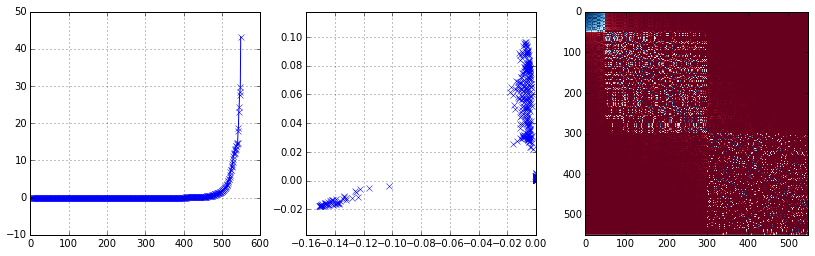

In [149]:
u,U = linalg.eig(K)
uidx = argsort(u)
v = U[:,uidx][:,-1]
vidx = argsort(v)
fig,ax = subplots(nrows=1,ncols=3,figsize=(14,4))
ax[0].plot(range(n), u[uidx],'x-'); ax[0].grid()
#ax[1].plot(range(n), v[vidx],'x-'); ax[1].grid()
ax[1].plot(U[:,uidx][:,-1],U[:,uidx][:,-2],'x'); ax[1].grid()
ax[1].axis('equal')
im = ax[2].imshow(K[ix_(vidx,vidx)],**kernel_plot_props)

###unnormalized graph Laplacian (avg cut)

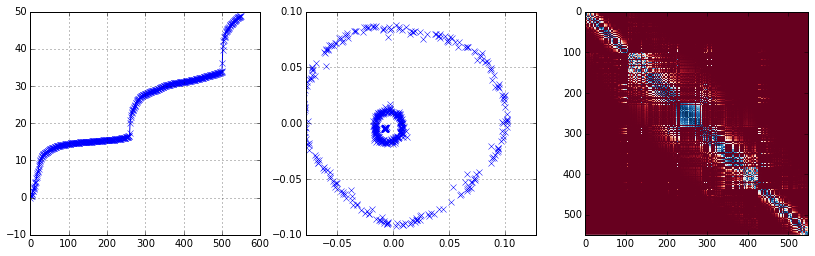

In [147]:
D = diag(sum(K,axis=0))
u,U = linalg.eig((D - K))
uidx = argsort(u)
v = (U[:,uidx])[:,1]
vidx = argsort(v)
fig,ax = subplots(nrows=1,ncols=3,figsize=(14,4))
ax[0].plot(range(n), u[uidx],'x-'); ax[0].grid()
#ax[1].plot(range(n), v[vidx],'x-'); ax[1].grid()
ax[1].plot((U[:,uidx])[:,1],(U[:,uidx])[:,2],'x'); ax[1].grid(); ax[1].axis('equal')
im = ax[2].imshow(K[ix_(vidx,vidx)],**kernel_plot_props)

### normalized graph Laplacian (ncut)

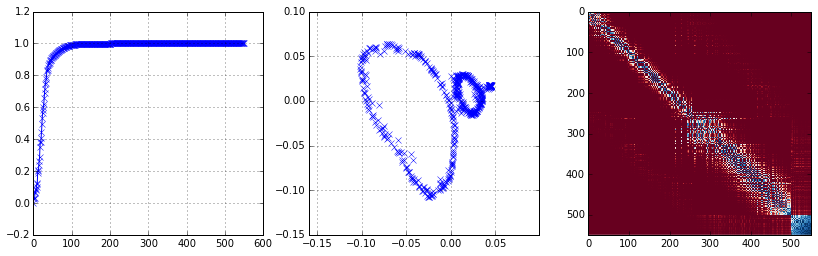

In [148]:
D = diag(1./sqrt(sum(K,axis=0)))
u,U = linalg.eig( identity(n) - D.dot(K).dot(D))
uidx = argsort(u)
v = U[:,uidx][:,1]
vidx = argsort(v)
fig,ax = subplots(nrows=1,ncols=3,figsize=(14,4))
ax[0].plot(range(n), u[uidx],'x-'); ax[0].grid()
#ax[1].plot(range(n), v[vidx],'x-'); ax[1].grid()
ax[1].plot(U[:,uidx][:,1],U[:,uidx][:,2],'x'); ax[1].grid(); ax[1].axis('equal')
im = ax[2].imshow(K[ix_(vidx,vidx)],**kernel_plot_props)

##Reference
<a id='dhillon'/></a>[1]: I. Dhillon, Y. Guan, and B. Kulis, *A unified view of kernel k-means, spectral clustering and graph cuts*, 2004.

<a id='luxburg'/></a>[2]: U. von Luxburg, *A tutorial on spectral clustering*, 2007.

<a id='bach'/></a>[3]: F. R. Bach and M. I. Jordan, *Learning Spectral Clustering*, 2003.

<a id='chi'/></a>[4]: Y. Chi, X. Song, D. Zhou, K. Hino, and B. L. Tseng, *Evolutionary Spectral Clustering by Incorporating Temporal Smoothness*, 2007.